# Frequency correlation plots for simulated populations with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.1

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/simulated/simulated_sample_3"

In [9]:
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_tree"

In [10]:
first_validation_timepoint = "2023-10-01"

In [11]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [12]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
#tips = np.round(tips, precision)

In [14]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.0


In [15]:
(tips["frequency"] > 0).sum()

22050

In [16]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [17]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [18]:
tips_to_clades.head(20)

,strain,clade_membership,depth
0,sample_6160_82,371216c,0
1,sample_6160_82,bf38b41,2
2,sample_6160_82,adc6bab,3
3,sample_6164_8,371216c,0
4,sample_6164_8,bf38b41,2
5,sample_6164_8,adc6bab,3
6,sample_6156_7,c29d627,0
7,sample_6156_7,441d6bc,2
8,sample_6156_7,bf38b41,3
9,sample_6156_7,adc6bab,4


In [19]:
tips_to_clades.shape

(258040, 3)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [21]:
#forecasts = np.round(forecasts, precision)

In [22]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,2016-10-01,sample_3236_14,0.0,0.0


In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [25]:
#full_forecasts = np.round(full_forecasts, precision)

In [26]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
8820,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01
8821,2023-10-01,sample_4636_10,0.000013,7.028772,8.791790,10.839396,1.302234e-06,4.849536,2024-10-01
8822,2023-10-01,sample_4636_24,0.000013,7.284332,9.838817,7.679263,5.524085e-08,5.210227,2024-10-01
8823,2023-10-01,sample_4636_27,0.000013,7.015142,8.779956,-39.344027,2.090765e-28,4.841702,2024-10-01
8824,2023-10-01,sample_4636_33,0.000013,13.189609,15.763376,10.898216,1.381129e-06,11.270201,2024-10-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [27]:
tips.head()

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.000013
8821,sample_4636_10,2023-10-01,0.000013
8822,sample_4636_24,2023-10-01,0.000013
8823,sample_4636_27,2023-10-01,0.000013
8824,sample_4636_33,2023-10-01,0.000013


In [28]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [29]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,sample_6160_82,371216c,0,2031-04-01,0.000116
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116
3,sample_6164_8,371216c,0,2031-04-01,0.000159
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159


In [30]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [31]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_6160_82,371216c,0,2031-04-01,0.000116,2032-04-01
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116,2032-04-01
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116,2032-04-01
3,sample_6164_8,371216c,0,2031-04-01,0.000159,2032-04-01
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159,2032-04-01


In [32]:
clade_tip_initial_frequencies.shape

(298675, 6)

In [33]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [34]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2031-04-01,2032-04-01,00bae18,0.001351
1,2031-04-01,2032-04-01,03167e3,0.162375
2,2031-04-01,2032-04-01,051218a,0.002874
3,2031-04-01,2032-04-01,09d720d,0.008704
4,2031-04-01,2032-04-01,0a86408,0.020425


In [35]:
initial_clade_frequencies.query("clade_membership == '8517059'")

,timepoint,future_timepoint,clade_membership,frequency


Merge clade frequencies between adjacent years.

In [36]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [37]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2031-04-01,03167e3,0.162375,0.980766
1,2031-04-01,1238505,0.470798,0.981053
2,2031-04-01,1b124f3,0.016757,0.000287
3,2031-04-01,236447c,0.930880,0.999936
4,2031-04-01,30dddad,0.438771,0.981053


In [38]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final


Select clades with an initial frequency >15%.

In [39]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [40]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2031-04-01,03167e3,0.162375,0.980766
1,2031-04-01,1238505,0.470798,0.981053
3,2031-04-01,236447c,0.930880,0.999936
4,2031-04-01,30dddad,0.438771,0.981053
6,2031-04-01,695af4b,0.264314,0.018883


In [41]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
846,2039-10-01,e6d6cf6,0.999977,0.999954
848,2039-10-01,eae51b9,0.109302,0.001209
849,2039-10-01,f13c38d,0.999977,0.999954
850,2039-10-01,f1e64ed,0.474601,0.999954
851,2039-10-01,fcc72c3,0.999977,0.999954


In [42]:
large_clades.shape

(449, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [43]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [44]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_6160_82,371216c,0,2031-04-01,0.000116,1.478994e-05
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116,1.478994e-05
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116,1.478994e-05
3,sample_6164_8,371216c,0,2031-04-01,0.000159,3.590551e-14
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159,3.590551e-14


In [45]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [46]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2031-04-01,00bae18,1.140116e-04
1,2031-04-01,03167e3,6.055102e-01
2,2031-04-01,051218a,1.196860e-11
3,2031-04-01,09d720d,8.444445e-08
4,2031-04-01,0a86408,5.899229e-03


In [47]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [48]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [49]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [50]:
complete_clade_frequencies.shape

(159, 5)

In [51]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [52]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

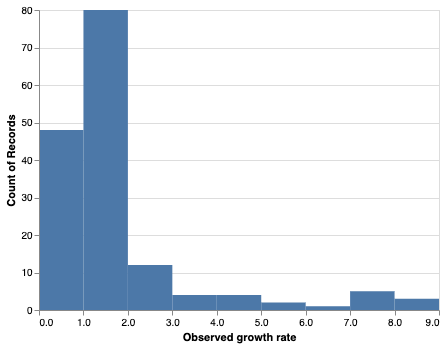

In [53]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [54]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [55]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
0,2031-04-01,03167e3,0.16,0.98,0.61,6.125000,3.812500,2031
1,2031-04-01,1238505,0.47,0.98,0.72,2.085106,1.531915,2031
2,2031-04-01,236447c,0.93,1.00,0.98,1.075269,1.053763,2031
3,2031-04-01,30dddad,0.44,0.98,0.72,2.227273,1.636364,2031
4,2031-04-01,695af4b,0.26,0.02,0.21,0.076923,0.807692,2031


In [56]:
complete_clade_frequencies.shape

(159, 8)

In [57]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [58]:
r

0.32643946302035476

In [59]:
p

2.6763093747569896e-05

In [60]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [61]:
mcc

0.4042472950645035

In [62]:
confusion_matrix

{'tp': 86, 'tn': 31, 'fp': 17, 'fn': 25}

In [63]:
sum(confusion_matrix.values())

159

In [64]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.8349514563106796

In [65]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5535714285714286

In [66]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [67]:
pseudofrequency = 0.001

In [68]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [73]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

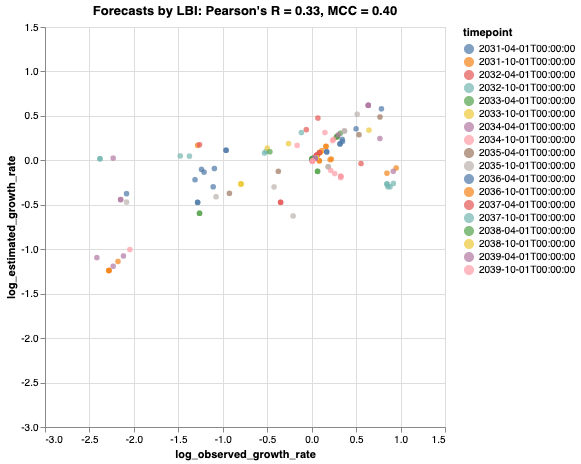

In [74]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [75]:
log_lower_limit

-2.516640507338281

In [76]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.416640507338281

In [77]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [78]:
r

0.6588457538182222

In [79]:
p

3.7362065073996626e-21

In [80]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.32643946302035476, 2.6763093747569896e-05)

In [81]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [82]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [83]:
complete_clade_frequencies.aggregate({"observed_growth": "sum", "estimated_growth": "sum"})

observed_growth     111
estimated_growth    103
dtype: int64

In [84]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [85]:
confusion_matrix

{'tp': 86, 'tn': 31, 'fp': 17, 'fn': 25}

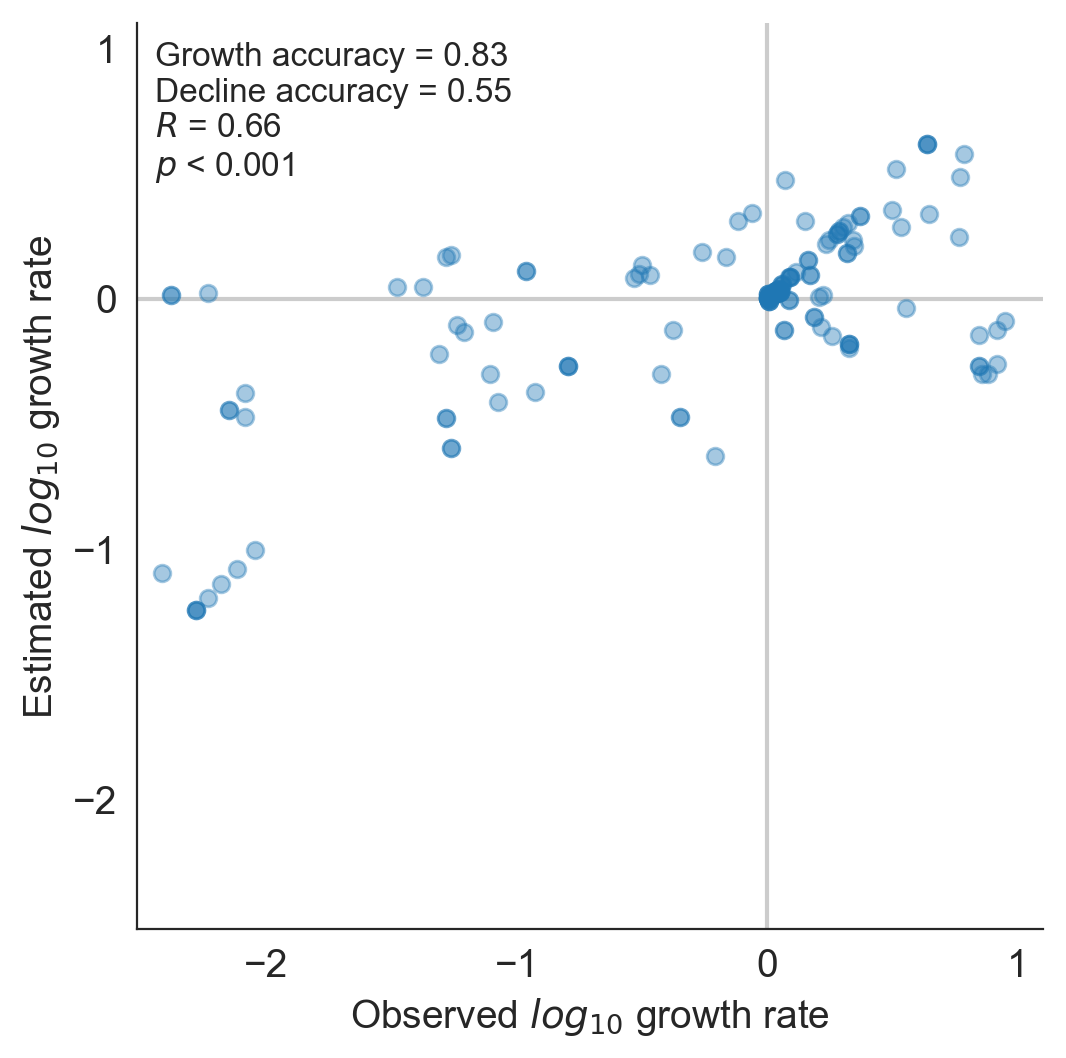

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

In [88]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [89]:
confusion_matrix

{'tp': 86, 'tn': 31, 'fp': 17, 'fn': 25}

In [90]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
197,2036-04-01,4fdb3cd,0.10,0.01,0.13,0.100000,1.300000,2036,-0.962929,0.112950,False,True,False
190,2036-04-01,1a36f43,0.10,0.01,0.13,0.100000,1.300000,2036,-0.962929,0.112950,False,True,False
369,2038-10-01,c4774df,0.11,0.06,0.17,0.545455,1.545455,2038,-0.259993,0.187673,False,True,False
322,2038-04-01,8150f4d,0.12,0.04,0.15,0.333333,1.250000,2038,-0.470002,0.096192,False,True,False
82,2033-10-01,8d6504d,0.16,0.05,0.22,0.312500,1.375000,2033,-0.499256,0.137566,False,True,False
389,2039-04-01,4e6e637,0.17,0.00,0.18,0.000000,1.058824,2039,-2.232996,0.024682,False,True,False
291,2037-10-01,8f812d8,0.17,0.13,0.35,0.764706,2.058824,2037,-0.115725,0.312311,False,True,False
126,2034-10-01,d48329b,0.19,0.13,0.28,0.684211,1.473684,2034,-0.163762,0.167673,False,True,False
262,2037-04-01,a2f1320,0.20,0.01,0.30,0.050000,1.500000,2037,-1.261803,0.175370,False,True,False
232,2036-10-01,a125a94,0.21,0.01,0.31,0.047619,1.476190,2036,-1.282890,0.168478,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [91]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [92]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [93]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [94]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.170635
1,2024-04-01,0.688889
2,2024-10-01,0.222222
3,2025-04-01,0.306349
4,2025-10-01,0.039683


Text(0,0.5,'Number of timepoints')

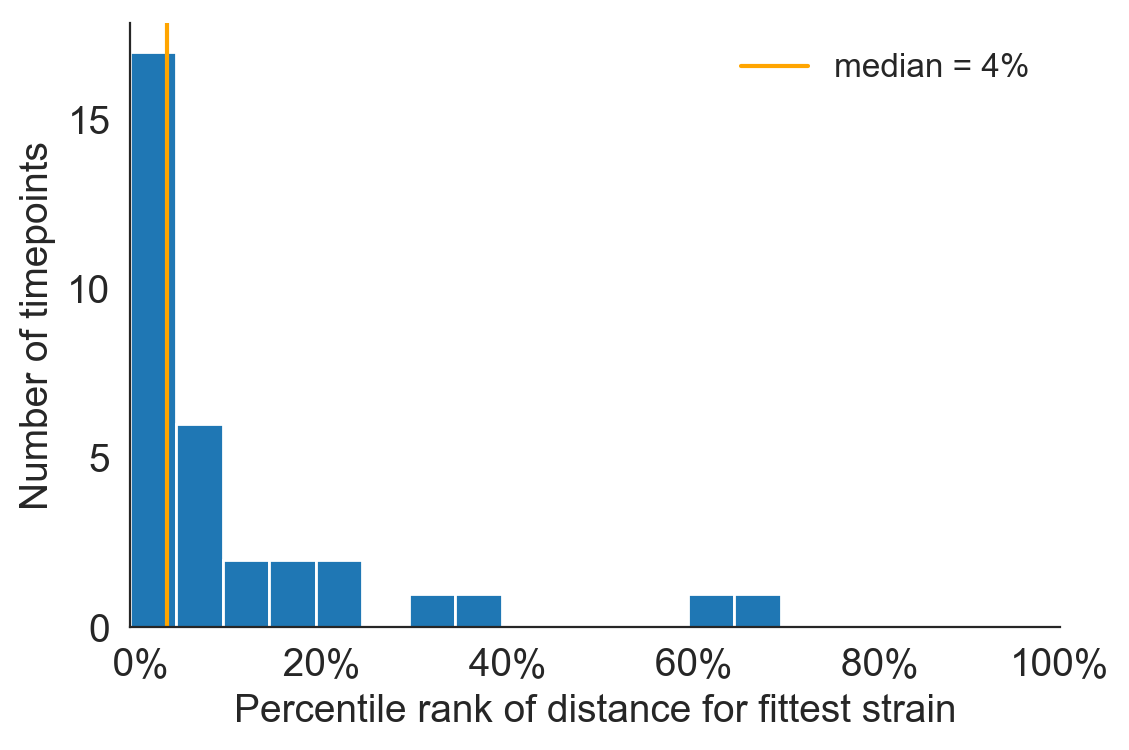

In [95]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

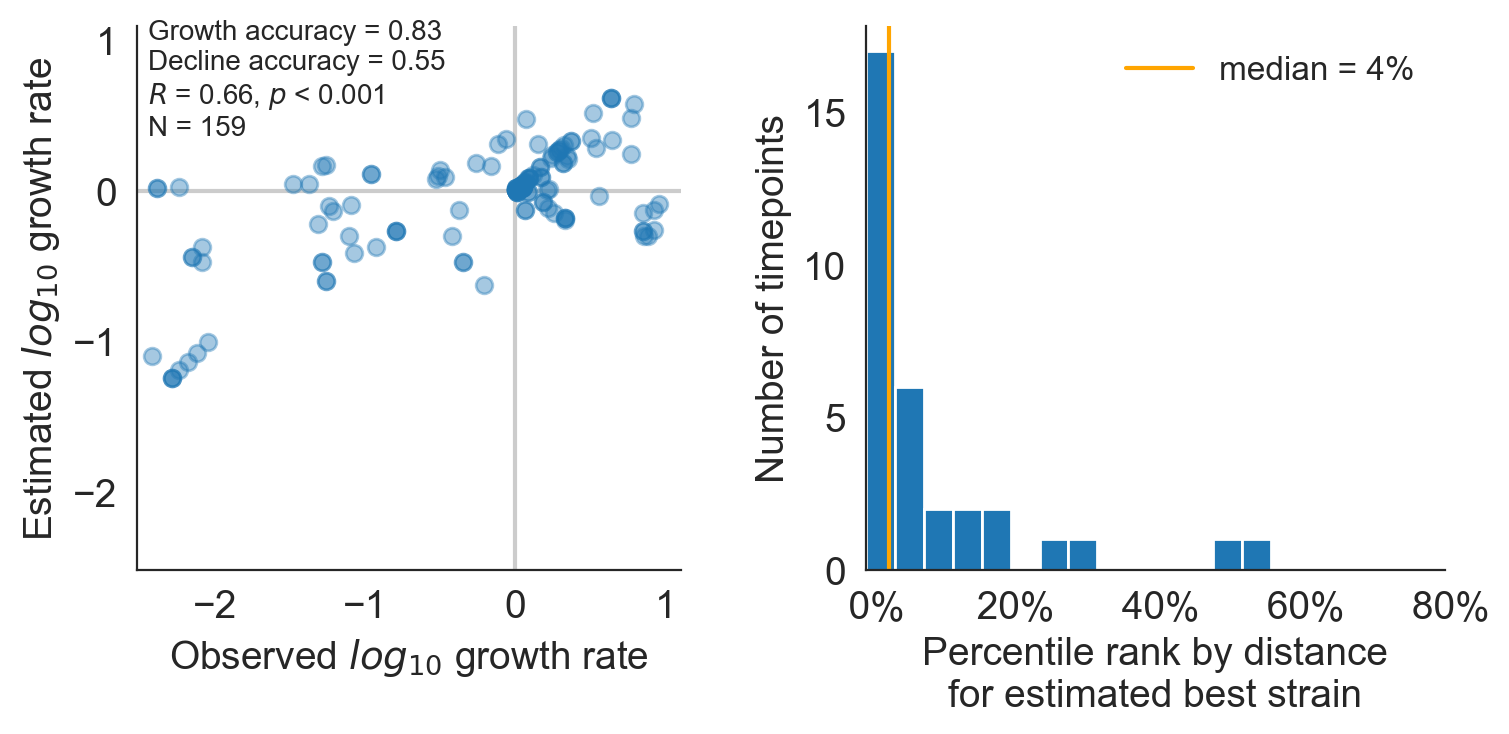

In [96]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")

In [97]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

27

In [98]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [99]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.8181818181818182